In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../')
import configparser
from sage_tabular_model import SAGE_tabular
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pk
import pandas as pd
import numpy  as np
from dataset_preprocessor import DataPreprocessor
import pandas as pd
import seaborn as sns

Using backend: pytorch


In [3]:
working_folder = '/home/jovyan/upamo-storage/Alexey_jr/geo2vec/GCN/DGL_pipeline/CheckResults'

In [4]:
dataset = pd.read_pickle(f'{working_folder}/test_data.pkl')

In [4]:
dataset['y_cred'].describe()

count     113.000000
mean      337.626174
std       456.374411
min        19.044155
25%        93.917360
50%       144.798178
75%       311.961863
max      2273.547256
Name: y_cred, dtype: float64

/home/virtual_envs/gcn_libs/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_cred', ylabel='Density'>

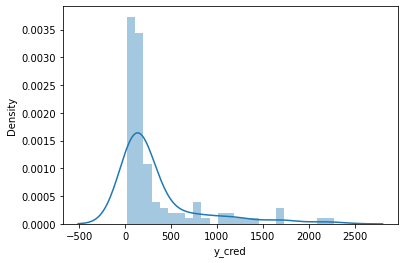

In [5]:
sns.distplot(dataset['y_cred'])

In [4]:
with open(f'{working_folder}/../selected_feats.pkl', 'rb') as fp: 
    feat_cols = pk.load(fp)
with open(f'{working_folder}/../selected_cats.pkl', 'rb') as fp: 
    cat_cols = pk.load(fp)

In [5]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [6]:
import os

In [7]:
from tqdm import tqdm 
from collections import defaultdict

In [8]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [9]:
# mape = []
# mae = []
# mse = []
# smapes = []
result = defaultdict(list)
targets = ['y_cred', 'y_deps_delta', 'y_comm']
for i in tqdm(range(5)):
    for target in tqdm(targets, leave=False):
        pred_y_cred = pd.read_pickle(f'{working_folder}/model_folder/model{i}_{target}/pred_{target}.pkl')
        test_data = pd.read_pickle(f'{working_folder}/folds/test{i}')
        res = test_data[[target, 'num']].merge(pred_y_cred, on='num')
        result['mape'] += [mean_absolute_percentage_error(res[target].values, res['pred'].values)]
        result['mae'] += [mean_absolute_error(res[target].values, res['pred'].values)]
        result['mse'] += [mean_squared_error(res[target].values, res['pred'].values)]
        result['smapes'] += [smape(res[target].values, res['pred'].values)]
        result['targ'] += [target]

100%|██████████| 5/5 [11:05<00:00, 133.17s/it][A


In [10]:
res = pd.DataFrame(result)

In [11]:
kwargs = {i+'_mean':pd.NamedAgg(i, aggfunc='mean') for i in ['mape','mae','mse','smapes']}
kwargs.update({i+'_std':pd.NamedAgg(i, aggfunc='std') for i in ['mape','mae','mse','smapes']})

In [12]:
res = res.groupby('targ').agg(**kwargs)

In [13]:
res.to_pickle('results_fcnn_sage.pkl')

In [14]:
res

,mape_mean,mae_mean,mse_mean,smapes_mean,mape_std,mae_std,mse_std,smapes_std
targ,,,,,,,,
y_comm,0.886635,25.844818,1657.177438,162.304053,0.118728,3.235890,341.304789,31.895845
y_cred,0.920610,326.850319,362051.306852,172.710425,0.034590,62.263923,190997.416176,11.083717
y_deps_delta,1.110754,236.754148,583193.673187,165.887707,0.186131,73.399482,807404.286456,12.285009
